In [1]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (BatchNormalization, ConvLSTM2D, Dense,
                                     Input, LeakyReLU, Conv3D)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from_generator = tf.data.Dataset.from_generator

from DataPrep import DataPrep

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:

# TODO: add variables for frame height and width
# def input_fn(filepath, batch_size=10, segment_size=5):

filepath = 'data/train_sample_videos'
segment_size = 5
datapath = os.path.join(filepath, 'metadata.json')
data = pd.read_json(os.path.join(datapath)).T
files = [os.path.join(filepath, f) for f in data.index]
labels = data.label.values
x_train, x_test, y_train, y_test = train_test_split(
    files, labels, test_size=0.2)
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
for k, v in zip(np.unique(y_train), class_weights):
    print(k, v)
y_train = list(map(lambda x: 0 if x == 'REAL' else 1, y_train))
y_test = list(map(lambda x: 0 if x == 'REAL' else 1, y_test))
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(len(x_train), len(y_train), len(x_test), len(y_test))



FAKE 0.6177606177606177
REAL 2.622950819672131
320 320 80 80


In [4]:

# @tf.function
def input_fn(files, labels, segment_size=5, batch_size=1, rsz=(128, 128)):
    def dataGenerator():
        for f, label in zip(files, labels):
            dp = DataPrepDlib(segment_size=segment_size)
            # frames = dp.prepFullFrames(filepath=f)
            # flows = dp.getOpticalFlows()
            frames, flows = dp.prepVid(filepath=f)
            yield {'rgb_input': frames, 'flow_input': flows}, label
    dataset = from_generator(
        dataGenerator,
        output_types=(
            {
                "rgb_input": tf.int8,
                "flow_input": tf.float32
            },
            tf.int8),
        output_shapes=(
            {
                "rgb_input": (segment_size, rsz[0], rsz[1], 3),
                "flow_input": (segment_size - 1, rsz[0], rsz[1], 2)
            },
            (2,))
    )
    dataset = dataset.batch(batch_size)
    return dataset



In [5]:
batch_size = 10
train_data = input_fn(x_train, y_train, batch_size=batch_size)
test_data = input_fn(x_test, y_test, batch_size=batch_size)



In [6]:
class InputStream(tf.keras.Model):
    def __init__(self, kernel_size, filters, name):
        super().__init__(name=name)
        self.convLstm1 = ConvLSTM2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=1,
            padding='same',
            data_format='channels_last',
            return_sequences=True,
            dropout=0.5
        )
        self.bn1 = BatchNormalization()
        self.convLstm2 = ConvLSTM2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=1,
            padding='same',
            data_format='channels_last',
            return_sequences=True,
            dropout=0.5
        )
        self.bn2 = BatchNormalization()
        self.convLstm3 = ConvLSTM2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=1,
            padding='same',
            data_format='channels_last',
            return_sequences=False,
            dropout=0.5
        )
        self.bn3 = BatchNormalization()
        self.act = LeakyReLU()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = Dense(128)
        self.act1 = LeakyReLU()
        self.dense2 = Dense(128)
        self.act2 = LeakyReLU()
        self.dense3 = Dense(128)
        self.act3 = LeakyReLU()
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.out_layer = Dense(2)

    # TODO: specify different behavior for training, i.e. dropout only when
    # training
    def call(self, input_tensor, training=False):
        x = self.convLstm1(input_tensor)
        x = self.bn1(x)
        x = self.convLstm2(x)
        x = self.bn2(x)
        x = self.convLstm3(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.act1(x)
        x = self.dense2(x)
        x = self.act2(x)
        x = self.dense3(x)
        x = self.act3(x)
        if training:
            x = self.dropout(x)
        return self.out_layer(x)



In [7]:
# class InputStream(tf.keras.Model):
#     def __init__(self, kernel_size, filters, name):
#         super().__init__(name=name)

# kernel_size = 3
# filters = 1
# rgb_input = tf.keras.Input(shape=(5, 256, 256, 3), name='rgb_input')
# convLstm1 = ConvLSTM2D(
#     filters=filters,
#     kernel_size=kernel_size,
#     strides=1,
#     padding='same',
#     data_format='channels_last',
#     return_sequences=True,
#     dropout=0.5
# )(rgb_input)
# bn = BatchNormalization()(convLstm1)
# convLstm2 = ConvLSTM2D(
#     filters=filters,
#     kernel_size=kernel_size,
#     strides=1,
#     padding='same',
#     data_format='channels_last',
#     return_sequences=False,
#     dropout=0.5
# )(bn)
# bn = BatchNormalization()(convLstm2)
# flatten = tf.keras.layers.Flatten()(bn)
# dense = Dense(512)(flatten)
# act = LeakyReLU()(dense)
# dense = Dense(512)(act)
# act = LeakyReLU()(dense)
# dense = Dense(512)(act)
# act = LeakyReLU()(dense)
# dropout = tf.keras.layers.Dropout(0.5)(act)
# out_layer = Dense(2)(dropout)
# model = Model(inputs=rgb_input, outputs=out_layer)
# model.summary()



In [8]:
rgb_stream = InputStream(3, 4, 'rgb_stream')
flow_stream = InputStream(3, 4, 'flow_stream')
rgb_input = tf.keras.Input(shape=(5, 256, 256, 3), name='rgb_input')
flow_input = tf.keras.Input(shape=(4, 256, 256, 2), name='flow_input')
rgb = rgb_stream(rgb_input)
flow = flow_stream(flow_input)
final_average = tf.keras.layers.average([rgb, flow])
x = tf.keras.layers.Flatten()(final_average)
final_output = Dense(2, activation='softmax', name='final_output')(x)
model = Model(
    inputs={"rgb_input": rgb_input, "flow_input": flow_input},
    outputs=final_output,
    name='my_model'
)
model.summary()


Model: "my_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rgb_input (InputLayer)          [(None, 5, 256, 256, 0                                            
__________________________________________________________________________________________________
flow_input (InputLayer)         [(None, 4, 256, 256, 0                                            
__________________________________________________________________________________________________
rgb_stream (InputStream)        (None, 2)            33591250    rgb_input[0][0]                  
__________________________________________________________________________________________________
flow_stream (InputStream)       (None, 2)            33591106    flow_input[0][0]                 
___________________________________________________________________________________________

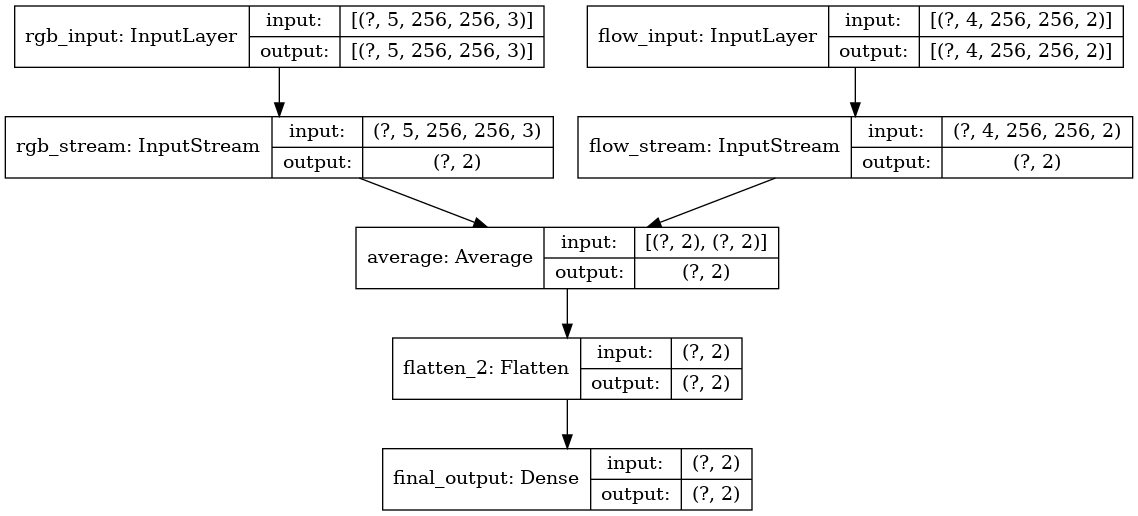

In [9]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
)



In [10]:
opt = tf.keras.optimizers.Adam()
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['acc'])
model.fit(
    train_data,
    epochs=10,
    verbose=1,
    class_weight=class_weights
)



Epoch 1/10
32/32 [==============================] - 143s 4s/step - loss: 8.4851 - acc: 0.7188
Epoch 2/10
32/32 [==============================] - 126s 4s/step - loss: 4.7678 - acc: 0.6531
Epoch 3/10
32/32 [==============================] - 121s 4s/step - loss: 2.6671 - acc: 0.6969
Epoch 4/10
32/32 [==============================] - 125s 4s/step - loss: 2.0180 - acc: 0.7437
Epoch 5/10
32/32 [==============================] - 124s 4s/step - loss: 1.2356 - acc: 0.7094
Epoch 6/10
32/32 [==============================] - 121s 4s/step - loss: 1.2291 - acc: 0.6750
Epoch 7/10
32/32 [==============================] - 123s 4s/step - loss: 0.9215 - acc: 0.7406
Epoch 8/10
32/32 [==============================] - 123s 4s/step - loss: 0.8768 - acc: 0.7281
Epoch 9/10
32/32 [==============================] - 122s 4s/step - loss: 0.8040 - acc: 0.7594
Epoch 10/10
32/32 [==============================] - 123s 4s/step - loss: 0.7563 - acc: 0.7344


In [11]:
model.evaluate(
    test_data,
    #     class_weight=class_weights
)



8/8 [==============================] - 29s 4s/step - loss: 0.7828 - acc: 0.5750


[0.7827930524945259, 0.575]

In [ ]:
# DEBUGGING
dataset = input_fn(filepath, batch_size=1)
start = time.time()
for i, x in enumerate(dataset):
    print(i)
    data_dict, label = x
    for k, v in data_dict.items():
        print(k, v.numpy().shape)
    print(time.time() - start)



In [ ]:
filepath = 'data/train_sample_videos'
segment_size = 5
datapath = os.path.join(filepath, 'metadata.json')
data = pd.read_json(os.path.join(datapath)).T
files = [os.path.join(filepath, f) for f in data.index]
labels = data.label.apply(lambda x: 0 if x == 'REAL' else 1)
labels = to_categorical(labels, num_classes=2)
for i, (f, label) in enumerate(zip(files, labels)):
    try:
        dp = DataPrep(segment_size=segment_size)
        frames = dp.prepFullFrames(filepath=f)
        flows = dp.getOpticalFlows()
    except Exception as e:
        print(i, f, label)
        print(e)
        break
print('everything is working now')



In [ ]:
f = 'data/train_sample_videos/adhsbajydo.mp4'
dp = DataPrep(segment_size=segment_size)
frames = dp.prepFullFrames(filepath=f)
